In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.patches as mpatches

Reading data from drive and converting it to csv format

In [ ]:
dataset=pd.read_csv("/content/drive/MyDrive/ML Data/data_banknote_authentication.txt")
dataset.to_csv("/content/drive/MyDrive/ML Data/data_banknote_authentication.csv",index=None)

In [ ]:
print(dataset)

       3.6216    8.6661  -2.8073  -0.44699  0
0     4.54590   8.16740  -2.4586  -1.46210  0
1     3.86600  -2.63830   1.9242   0.10645  0
2     3.45660   9.52280  -4.0112  -3.59440  0
3     0.32924  -4.45520   4.5718  -0.98880  0
4     4.36840   9.67180  -3.9606  -3.16250  0
...       ...       ...      ...       ... ..
1366  0.40614   1.34920  -1.4501  -0.55949  1
1367 -1.38870  -4.87730   6.4774   0.34179  1
1368 -3.75030 -13.45860  17.5932  -2.77710  1
1369 -3.56370  -8.38270  12.3930  -1.28230  1
1370 -2.54190  -0.65804   2.6842   1.19520  1

[1371 rows x 5 columns]


In [ ]:
num_folds = 3
num_samples = 1371
num_features = 5
num_classes = 2
num_runs = 5
lr = 2
list_ratio = [.01,.02, .05 ,.1 ,.625, 1] 

In [ ]:
# function to train data using guassian naive bayes
def guassian_naive_bayes():

	# reading input, storing it in array nad initialising variables
	inp = dataset
	data = np.array(inp)
	means = means_avg = np.zeros((np.size(list_ratio),num_classes,num_features-1))
	variance = variance_avg = np.zeros((np.size(list_ratio), num_classes,num_features-1))
	means[:,:] = 0
	variance[:,:] = 0
	accuracy = np.zeros((1,np.size(list_ratio)))

	# calculating indices for validate data and training data		
	validate_index2 = (int)((num_samples/num_folds)-1)
	validate_index1 = (int)(validate_index2 - (num_samples/num_folds) + 1)

	# extracting validate data and training data
	training_data = np.vstack((data[:(np.absolute(validate_index1-1)),:],data[(validate_index2+1):,:]))
	validate_data = data[validate_index1:validate_index2, :]

	# looping over the list of training sampling ratios
	for ratio in range(np.size(list_ratio)):

		training_set = np.zeros(((int)(list_ratio[ratio]*training_data.shape[0]),(num_features)))

		# looping for no:of runs
		for runs in range(0,num_runs):
			means[ratio,:] = 0
			variance[ratio,:] = 0

			# extracting random rows from training set for each ratio
			training_set[:,:] = training_data[np.random.choice(training_data.shape[0],size = (int)(list_ratio[ratio]*training_data.shape[0]) , replace=False), :]
			
			# calculating guassian means for the independent parameters of features
			for j in range(0,num_classes):
				for k in range(0,num_features-1):
					means[ratio,j,k] = gnb_mean_esti(j,k,training_set)
			means_avg[ratio,j,k] += means[ratio,j,k]

			# calculating guassian variances for independent parameters of features
			for j in range(0,2):
				for k in range(0,4):
					variance[ratio,j,k] = gnb_var_esti(j,k,training_set,means[ratio,:,:])
				variance_avg[ratio,j,k] += variance[ratio,j,k]

			# validating the parameters and finding accuracy for each sampling ratio	
			accuracy[0,ratio] += gnb_validate(validate_data,means[ratio,:,:],variance[ratio,:,:])
		
		# averaging the accuracies
		accuracy[0,ratio] /= num_runs
		print(accuracy[0,ratio])

	return (accuracy,means_avg,variance_avg)

In [ ]:
# validate function which takes validation data, guassian means and variances and return accuracy
def gnb_validate(validate_data,means,variance):
	
	num_pos_samples = 0

	# finding no:of positive nad negative samples
	for i in range(0,validate_data.shape[0]):		
		num_pos_samples += validate_data[i,num_features-1]
	num_neg_samples = validate_data.shape[0]-num_pos_samples

	# finding bernoulli parameter of class variable
	py0 = num_neg_samples/(num_neg_samples+num_pos_samples)
	py1 = 1-py0
	num_crct_pred = 0	

	# looping over the entire validation data
	for length in range(0,validate_data.shape[0]):
		# variables for likelihood probability estimation
		prod_pxy0 = prod_pxy1 = 1

		# finding the likelihood probabilities
		for i in range(0,num_features-1):
			prod_pxy0 *= calculate_guassian(validate_data[length,i],means[0,i],variance[0,i])
			prod_pxy1 *= calculate_guassian(validate_data[length,i],means[1,i],variance[1,i])
		
		# finding the posterior probabilities, predicting class and comparing with actual value of class to find accuracy
		py0x = (prod_pxy0*py0)/(prod_pxy0*py0 + prod_pxy1*py1)
		if py0x <= 0.5:
			if validate_data[length,4] == 1:
				num_crct_pred += 1
		else :
			if validate_data[length,4] == 0:
				num_crct_pred += 1

	accuracy = num_crct_pred/(validate_data.shape[0])

	return accuracy

In [ ]:
# function to return the guassian probability
def calculate_guassian(x,mean,variance):
	result = (np.exp(-(np.power(x-mean,2)/variance)))/(np.sqrt(2*3.14*variance))
	return result

In [ ]:
# function for estimating the means of features
def gnb_mean_esti(class_type, feature,training_set):
	mean = 0
	num_pos_samples = 0
	
	# extracing no:of positive and negative samples to find means
	for i in range(0,training_set.shape[0]):		
		num_pos_samples += training_set[i,num_features-1]		

		if training_set[i,num_features-1] == class_type:
			mean += training_set[i,feature]

	# checking class type and calculating means
	if (class_type):
		mean = mean/num_pos_samples
	else:
		mean = mean/(training_set.shape[0]-num_pos_samples)
	return mean

In [ ]:
# function for estimating variances of features 
def gnb_var_esti(class_type,feature,training_set,means):
	variance = 0
	num_pos_samples = 0
	
	# extracing no:of positive and negative samples to find variances
	for i in range(0,training_set.shape[0]):
		num_pos_samples += training_set[i,num_features-1]

		if training_set[i,num_features-1] == class_type:
			variance += np.power((training_set[i,feature]-means[class_type,feature]),2)	
	
	# checking class type and calculating unbiased variances
	if (class_type):
		variance = variance/(num_pos_samples-1)
	else:
		variance = variance/((training_set.shape[0]-num_pos_samples)-1)	

	return variance

In [ ]:
gnb_accuracy = np.array(np.size(list_ratio))  # to store the accuracy of gaussian naive bayes model

In [ ]:
gnb_means = np.zeros((np.size(list_ratio),num_classes,num_features-1))	# to store the guassian means of gaussian naive bayes model
gnb_variance = np.zeros((np.size(list_ratio),num_classes,num_features-1))	# to store the guassian variances of gaussian naive bayes model

In [ ]:
(gnb_accuracy,gnb_means,gnb_variance) = guassian_naive_bayes()
# converting accuracies to percentage scale
gnb_accuracy *= 100
gnb_accuracy = np.reshape(gnb_accuracy,6)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


1.0
1.0
1.0
1.0
1.0
1.0


In [ ]:
print("\n means of gnb model for different ratios:\n",gnb_means, "\n variances of gnb model:\n", gnb_variance)
print("\n accuracies of gnb model for different ratios:\n",gnb_accuracy)


 means of gnb model for different ratios:
 [[[ 3.5127      2.9073      1.0579      0.40774   ]
  [-1.66389125  1.1815425  -0.50409837 -2.6448135 ]]

 [[ 2.1927      7.44215833 -0.85911667 -2.2039    ]
  [-1.06363667 -0.36420917  0.46526833 -1.545268  ]]

 [[ 2.04038427  5.27099927  0.2367136  -1.27267627]
  [-2.19953497 -1.7573095   3.3247836  -2.92232867]]

 [[ 1.88080607  3.87389929  1.537951   -1.01531259]
  [-1.9939771  -1.936465    3.08698308 -2.6365773 ]]

 [[ 2.38630179  3.90811733  0.94674433 -0.93279311]
  [-1.83398495 -0.90479296  2.0656958  -2.45363262]]

 [[ 2.34807325  4.01158553  0.8924374  -1.02018651]
  [-1.86844256 -0.99357612  2.14827101 -2.49328149]]] 
 variances of gnb model:
 [[[        nan         nan         nan         nan]
  [ 2.89980458 11.49574288  3.77097254 16.44860109]]

 [[11.5989264  16.35175249  5.98065033 18.07575697]
  [ 1.53351408 15.65178151 13.96734124  5.7825458 ]]

 [[ 3.55496357 20.09406751  5.64580168  8.1001283 ]
  [ 4.12895995 37.49936044 32

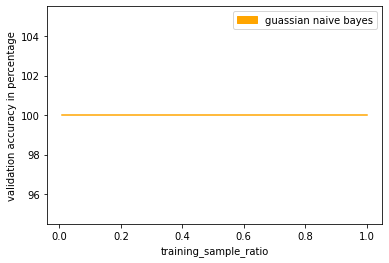

In [ ]:
plt.plot(list_ratio,gnb_accuracy,color = 'orange' )
plt.xlabel('training_sample_ratio')
plt.ylabel('validation accuracy in percentage')
orange_patch = mpatches.Patch(color='orange', label='guassian naive bayes')
plt.legend(handles=[orange_patch])
plt.show()

In [ ]:
rows = 613
columns = num_features-1
guassian_samples = np.zeros((rows,columns))
means_guassian_samples = np.zeros((1,num_features-1))

# taking the parameters obtained by training the data set with guassian naive bayes model and extracting random samples using numpy.random.normal
for i in range(0,num_features-1):
	temp = np.random.normal(gnb_means[5,1,i],np.sqrt(gnb_variance[5,1,i]),rows)
	guassian_samples[:,i] = temp
	# calculating means of randomly extracted samples using trained parameters
	means_guassian_samples[0,i] = np.mean(guassian_samples[:,i])

np.savetxt('samples.csv',guassian_samples,delimiter=',',newline='\n',header='GUASSIAN SAMPLES')

print("\n means obtained by training data set:\n ",gnb_means[5,1,:], "\n means of guassian samples:\n", means_guassian_samples)


 means obtained by training data set:
  [-1.86844256 -0.99357612  2.14827101 -2.49328149] 
 means of guassian samples:
 [[-1.84843673 -0.99077598  2.18948268 -2.26537807]]


In [ ]:
x=pd.read_csv("/content/samples.csv")
print(x)

                                # GUASSIAN SAMPLES
 1.003695  5.526895  1.635975            -6.126618
-1.038850  1.313449  12.166530           -1.678197
-4.367953  2.559885 -2.032393             1.610537
-3.106414 -5.096667  8.564504            -4.793493
-3.175428  2.588412  4.399655            -2.953925
...                                            ...
-1.737697 -1.307156 -0.413392            -0.349214
-6.430247 -3.452827 -2.263771            -2.161652
-0.306513  0.280939 -5.978949             1.761091
-3.220042 -3.949625  1.260494             0.914789
-2.105869 -5.194006  2.001931            -3.975626

[613 rows x 1 columns]
